In [1]:
MODELO = "VGG19"

In [2]:
import os
import keras
keras.__version__
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [4]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [5]:
keras.backend.tensorflow_backend.set_session(get_session())

# Directorios

In [6]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [30]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


# Modelo VGG19

In [31]:
from keras.applications.vgg19 import VGG19

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = VGG19(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3))

In [32]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [33]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 26,478,008
Trainable params: 26,478,008
Non-trainable params: 0
_________________________________________________________________


In [35]:
conv_base.trainable = False

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 26,478,008
Trainable params: 6,453,624
Non-trainable params: 20,024,384
_________________________________________________________________


In [37]:
if multi_gpu > 1:
    parallel_model = multi_gpu_model(model, gpus=multi_gpu)

# Optimizador

from keras_radam import RAdam

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
                       metrics=['categorical_accuracy'])

In [39]:
from keras import optimizers

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.RMSprop(lr=1e-4),
                       metrics=['categorical_accuracy'])

# Callbacks

In [41]:
from keras import callbacks

callbacks = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

# Entrenamiento

In [42]:
history = parallel_model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=500,
                                       validation_data=valid_generator,
                                       validation_steps=50,
                                       callbacks=callbacks)

Epoch 1/500
100/100 [==============================] - 43s 430ms/step - loss: 4.8397 - categorical_accuracy: 0.0084 - val_loss: 4.8059 - val_categorical_accuracy: 0.0106
Epoch 2/500
100/100 [==============================] - 40s 400ms/step - loss: 4.7824 - categorical_accuracy: 0.0131 - val_loss: 4.7955 - val_categorical_accuracy: 0.0101
Epoch 3/500
100/100 [==============================] - 40s 400ms/step - loss: 4.7693 - categorical_accuracy: 0.0128 - val_loss: 4.7373 - val_categorical_accuracy: 0.0200
Epoch 4/500
100/100 [==============================] - 40s 402ms/step - loss: 4.7479 - categorical_accuracy: 0.0184 - val_loss: 4.7180 - val_categorical_accuracy: 0.0215
Epoch 5/500
100/100 [==============================] - 40s 398ms/step - loss: 4.7338 - categorical_accuracy: 0.0163 - val_loss: 4.7112 - val_categorical_accuracy: 0.0250
Epoch 6/500
100/100 [==============================] - 40s 401ms/step - loss: 4.6960 - categorical_accuracy: 0.0238 - val_loss: 4.6980 - val_categoric

Epoch 49/500
100/100 [==============================] - 40s 398ms/step - loss: 3.9203 - categorical_accuracy: 0.1119 - val_loss: 3.7593 - val_categorical_accuracy: 0.1237
Epoch 50/500
100/100 [==============================] - 40s 403ms/step - loss: 3.8838 - categorical_accuracy: 0.1284 - val_loss: 3.7645 - val_categorical_accuracy: 0.1243
Epoch 51/500
100/100 [==============================] - 41s 409ms/step - loss: 3.8471 - categorical_accuracy: 0.1238 - val_loss: 3.7959 - val_categorical_accuracy: 0.1269
Epoch 52/500
100/100 [==============================] - 41s 406ms/step - loss: 3.8806 - categorical_accuracy: 0.1216 - val_loss: 3.7282 - val_categorical_accuracy: 0.1281
Epoch 53/500
100/100 [==============================] - 40s 397ms/step - loss: 3.8393 - categorical_accuracy: 0.1253 - val_loss: 3.7443 - val_categorical_accuracy: 0.1344
Epoch 54/500
100/100 [==============================] - 40s 404ms/step - loss: 3.8417 - categorical_accuracy: 0.1316 - val_loss: 3.7399 - val_cat

Epoch 97/500
100/100 [==============================] - 40s 396ms/step - loss: 3.4814 - categorical_accuracy: 0.1809 - val_loss: 3.3966 - val_categorical_accuracy: 0.1811
Epoch 98/500
100/100 [==============================] - 40s 400ms/step - loss: 3.4829 - categorical_accuracy: 0.1772 - val_loss: 3.3921 - val_categorical_accuracy: 0.1850
Epoch 99/500
100/100 [==============================] - 40s 400ms/step - loss: 3.4504 - categorical_accuracy: 0.1778 - val_loss: 3.3647 - val_categorical_accuracy: 0.2050
Epoch 100/500
100/100 [==============================] - 40s 400ms/step - loss: 3.4974 - categorical_accuracy: 0.1638 - val_loss: 3.3789 - val_categorical_accuracy: 0.1981
Epoch 101/500
100/100 [==============================] - 40s 398ms/step - loss: 3.4737 - categorical_accuracy: 0.1806 - val_loss: 3.3662 - val_categorical_accuracy: 0.1823
Epoch 102/500
100/100 [==============================] - 39s 395ms/step - loss: 3.4674 - categorical_accuracy: 0.1791 - val_loss: 3.3538 - val_

In [43]:
import pickle

# open a file, where you ant to store the data
file = open('./models/history_{}.pkl'.format(MODELO), 'wb')

# dump information to that file
pickle.dump(history.history, file)

# close the file
file.close()

# Graficos

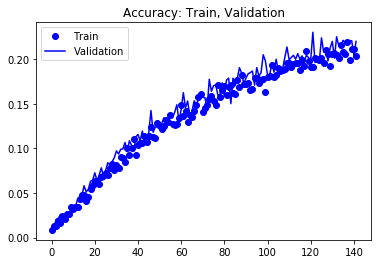

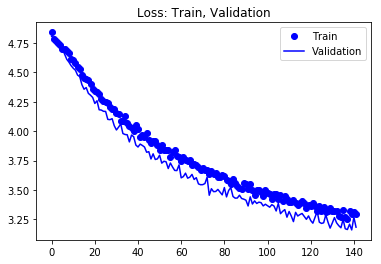

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [45]:
parallel_model.save('./models/model_{}_RAdam.h5'.format(MODELO))

# Predict

In [46]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 3025 images belonging to 120 classes.


In [47]:
probabilities = parallel_model.predict_generator(test_generator)

In [48]:
# Get Max Index
predicted_class_index=np.argmax(probabilities,axis=1)

# Dictionary: Index to Class
class_labels = list(test_generator.class_indices.keys())
index_to_labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Get List of Predictions
predictions = [index_to_labels[ix] for ix in predicted_class_index]

# Get Dictionary of Predictions
results=pd.DataFrame({"Filename":test_generator.filenames,
                      "Predictions":predictions})

In [49]:
results.head()

,Filename,Predictions
0,n02085620-Chihuahua\n02085620_10074.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua\n02085620_10131.jpg,n02087046-toy_terrier
2,n02085620-Chihuahua\n02085620_10621.jpg,n02105162-malinois
3,n02085620-Chihuahua\n02085620_1073.jpg,n02091244-Ibizan_hound
4,n02085620-Chihuahua\n02085620_10976.jpg,n02113023-Pembroke


In [50]:
results.to_csv("./models/results_details_{}.csv".format(MODELO), sep="|", index=False)

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class_index)

In [52]:
results_dict = {}
tp_sum, fp_sum = 0, 0

for ix, row in enumerate(cm):
    
    tp = row[ix]
    fp = np.sum(row) - tp   
    results_dict[ix] = [class_labels[ix],tp,fp,(tp/(tp+fp)*100)]

    tp_sum += tp
    fp_sum += fp
    
df_res = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Class","True Positive","False Positive","Accuracy"])

print("General Accuracy:{:0.2f}".format(tp_sum/(tp_sum+fp_sum)))

General Accuracy:0.21


In [53]:
df_res.head()

,Class,True Positive,False Positive,Accuracy
0,n02085620-Chihuahua,2,20,9.090909
1,n02085782-Japanese_spaniel,14,13,51.851852
2,n02085936-Maltese_dog,17,20,45.945946
3,n02086079-Pekinese,2,20,9.090909
4,n02086240-Shih-Tzu,4,28,12.500000


In [54]:
df_res.to_csv("./models/results_{}.csv".format(MODELO), sep="|", index=False)